# WORKFLOW 2

In [1]:
# IMPORTS
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# GLOBAL VARIABLES
execution_count = 1  # Adjust as needed
window_size = 100

dates = ["2025-02-03", "2025-02-04"]

folder_to_save = "./experiment_plots"

In [3]:
# PREPARE DATA
df_list = []

for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-optimizedFunction-logs.csv'
    
    if os.path.exists(file_path):  # Check if file exists to avoid errors
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
        df['day'] = df['timestamp'].dt.date  # Extract date to a new column
        df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
        df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

        df_list.append(df)

# Concatenate all dataframes
df_all_days_optimized = pd.concat(df_list, ignore_index=True)


df_list = []

for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-baselineFunction-logs.csv'
    
    if os.path.exists(file_path):  # Check if file exists to avoid errors
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
        df['day'] = df['timestamp'].dt.date  # Extract date to a new column
        df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
        df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

        df_list.append(df)

# Concatenate all dataframes
df_all_days_baseline = pd.concat(df_list, ignore_index=True)

In [ ]:
# OPTIMIZED GRAPH
sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot execution time for different days
sns.lineplot(data=df_all_days_optimized, x='duration_minutes', y='smoothed_execution_time', hue='day', lw=2, palette="tab10")

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Optimized Execution Time (ms)')
plt.title('Optimized Execution Time Over Multiple Days (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "smoothed-optimized-execution-time-multiple-days")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show()

In [ ]:
# BASELINE GRAPH
sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot execution time for different days
sns.lineplot(data=df_all_days_optimized, x='duration_minutes', y='smoothed_execution_time', hue='day', lw=2, palette="tab10")

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Baseline Execution Time (ms)')
plt.title('Baseline Execution Time Over Multiple Days (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "smoothed-baseline-execution-time-multiple-days")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show()

In [ ]:
# same color per function

sns.set_theme(style="darkgrid")

# Add function type before merging
df_all_days_optimized["function"] = "optimized"
df_all_days_baseline["function"] = "baseline"

# Merge both DataFrames
df_all_days = pd.concat([df_all_days_optimized, df_all_days_baseline], ignore_index=True)

# Define color for optimized and baseline
optimized_color = sns.color_palette("Blues", n_colors=1)[0]  # Main blue shade
baseline_color = sns.color_palette("Oranges", n_colors=1)[0]  # Main orange shade

# Create the plot
plt.figure(figsize=(12, 6))

# Plot execution times with the same colors for optimized and baseline
for i, day in enumerate(df_all_days['day'].unique()):
    # Optimized function in slight shades of blue
    sns.lineplot(
        data=df_all_days[(df_all_days['day'] == day) & (df_all_days['function'] == "optimized")],
        x='duration_minutes', y='smoothed_execution_time',
        color=optimized_color, label=f'O - {day}' if i == 0 else "", lw=2
    )

    # Baseline function in slight shades of orange
    sns.lineplot(
        data=df_all_days[(df_all_days['day'] == day) & (df_all_days['function'] == "baseline")],
        x='duration_minutes', y='smoothed_execution_time',
        color=baseline_color, label=f'B - {day}' if i == 0 else "", lw=2
    )

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Function & Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "execution-times-rolling-avg-overlay.pdf")
plt.savefig(plot_filename)

# SHOW PLOT
plt.show()

In [ ]:
# Calculate the rolling standard deviation for both optimized and baseline functions
df_all_days_optimized['rolling_std'] = df_all_days_optimized['execution_time'].rolling(window=window_size).std()
df_all_days_baseline['rolling_std'] = df_all_days_baseline['execution_time'].rolling(window=window_size).std()


# EXECUTION TIME ROLLING AVG WITH LESS DOMINANT STANDARD DEVIATION BAND

sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time with thicker line
sns.lineplot(data=df_all_days_optimized, x='duration_minutes', y='smoothed_execution_time', 
             color=palette[0], label='Optimized Function (Smoothed)', lw=0.5)

# Add shaded area for standard deviation band with lower alpha
plt.fill_between(df_all_days_optimized['duration_minutes'],
                 df_all_days_optimized['smoothed_execution_time'] - df_all_days_optimized['rolling_std'],
                 df_all_days_optimized['smoothed_execution_time'] + df_all_days_optimized['rolling_std'],
                 color=palette[0], alpha=0.2)  # Lower alpha for less dominance

# Plot baseline function execution time with thicker line
sns.lineplot(data=df_all_days_baseline, x='duration_minutes', y='smoothed_execution_time', 
             color=palette[1], label='Baseline Function (Smoothed)', lw=0.5)

# Add shaded area for standard deviation band with lower alpha
plt.fill_between(df_all_days_baseline['duration_minutes'],
                 df_all_days_baseline['smoothed_execution_time'] - df_all_days_baseline['rolling_std'],
                 df_all_days_baseline['smoothed_execution_time'] + df_all_days_baseline['rolling_std'],
                 color=palette[1], alpha=0.2)  # Lower alpha for less dominance

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times (Smoothed with Standard Deviation Bands)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SHOW PLOT
plt.show()

---

In [17]:
# PREPARE DATA 
dfs_optimized = []
dfs_baseline = []

for day in dates:
    df_optimized = pd.read_csv(f"./logs_analysis/{day}/execution_{execution_count}/{day}-optimizedFunction-logs.csv")
    df_baseline = pd.read_csv(f"./logs_analysis/{day}/execution_{execution_count}/{day}-baselineFunction-logs.csv")
    
    # Convert 'timestamp' col to datetime and create 'duration_minutes' & 'smoothed_execution_time'
    df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
    df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])
    df_optimized['duration_minutes'] = (df_optimized['timestamp'] - df_optimized['timestamp'].min()).dt.total_seconds() / 60
    df_baseline['duration_minutes'] = (df_baseline['timestamp'] - df_baseline['timestamp'].min()).dt.total_seconds() / 60
    df_optimized['smoothed_execution_time'] = df_optimized['execution_time'].rolling(window=window_size).mean()
    df_baseline['smoothed_execution_time'] = df_baseline['execution_time'].rolling(window=window_size).mean()
    
    # Append to list
    dfs_optimized.append(df_optimized)
    dfs_baseline.append(df_baseline)

# Concatenate all days' data
df_optimized_all_days = pd.concat(dfs_optimized)
df_baseline_all_days = pd.concat(dfs_baseline)

In [ ]:
df_optimized_median = df_optimized_all_days.groupby('duration_minutes')['smoothed_execution_time'].median().reset_index()
df_baseline_median = df_baseline_all_days.groupby('duration_minutes')['smoothed_execution_time'].median().reset_index()

print(df_optimized_median)

In [19]:
df_optimized_std = df_optimized_all_days.groupby('duration_minutes')['smoothed_execution_time'].std().reset_index()
df_baseline_std = df_baseline_all_days.groupby('duration_minutes')['smoothed_execution_time'].std().reset_index()

---

/var/folders/3w/450cp8190_d0ny9_wdcmgsgc0000gn/T/ipykernel_6933/933850024.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_optimized_all_days.groupby('time_bin')['execution_time'].agg(['median', 'std']).reset_index()


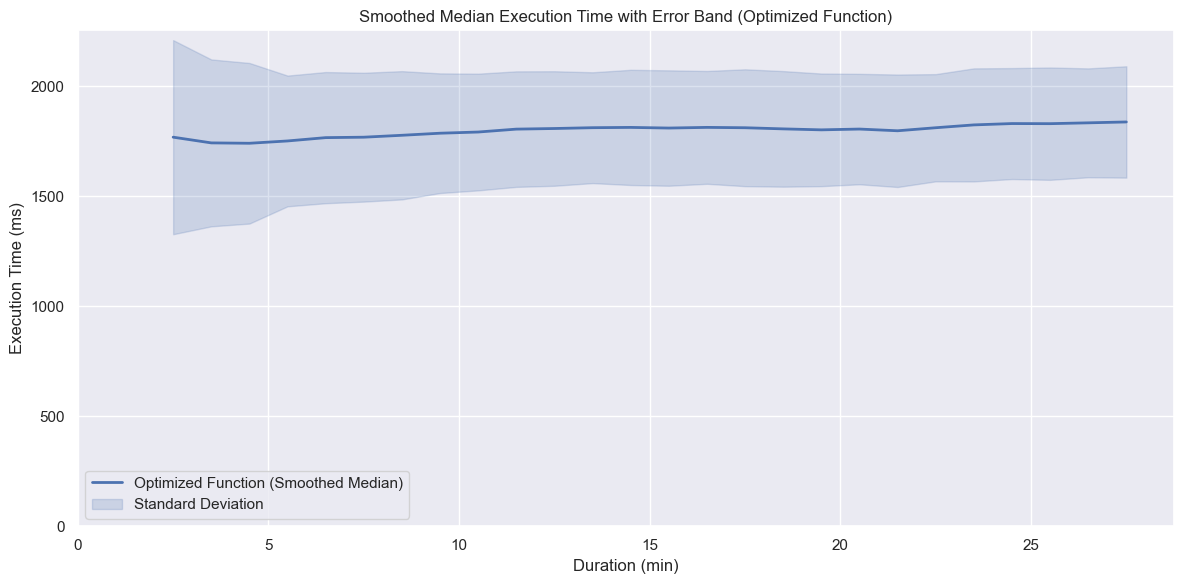

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import numpy as np


# df_all_days_optimized

# # Define the path to your CSV files
# path = "./logs_analysis/*/execution_*/*-optimizedFunction-logs.csv"
# all_files = glob.glob(path)

# # Read and concatenate all CSV files
# df_list = []
# for filename in all_files:
#     df = pd.read_csv(filename)
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60
#     df_list.append(df)

df_optimized_all_days = df_all_days_optimized

# Calculate the median and standard deviation for each time point
df_optimized_all_days['time_bin'] = pd.cut(df_optimized_all_days['duration_minutes'], bins=np.arange(0, 31, 1))
grouped = df_optimized_all_days.groupby('time_bin')['execution_time'].agg(['median', 'std']).reset_index()

# Calculate the midpoint of each bin for plotting
grouped['duration_minutes'] = grouped['time_bin'].apply(lambda x: x.mid)

# Smooth the median and standard deviation using a rolling window
window_size = 5  # Adjust the window size as needed
grouped['smoothed_median'] = grouped['median'].rolling(window=window_size, center=True).mean()
grouped['smoothed_std'] = grouped['std'].rolling(window=window_size, center=True).mean()

# Plot the data
sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

plt.figure(figsize=(12, 6))

# Plot smoothed median execution time
sns.lineplot(data=grouped, x='duration_minutes', y='smoothed_median', color=palette[0], label='Optimized Function (Smoothed Median)', lw=2)

# Add error band using standard deviation
plt.fill_between(grouped['duration_minutes'], 
                 grouped['smoothed_median'] - grouped['smoothed_std'], 
                 grouped['smoothed_median'] + grouped['smoothed_std'], 
                 color=palette[0], alpha=0.2, label='Standard Deviation')

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Smoothed Median Execution Time with Error Band (Optimized Function)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# Show plot
plt.show()

In [7]:
print(df_optimized_all_days.columns)

Index(['count', 'timestamp', 'execution_id', 'log', 'retries',
       'execution_time', 'benchmark_duration', 'download_duration',
       'lr_duration', 'day', 'duration_minutes', 'smoothed_execution_time',
       'time_bin'],
      dtype='object')


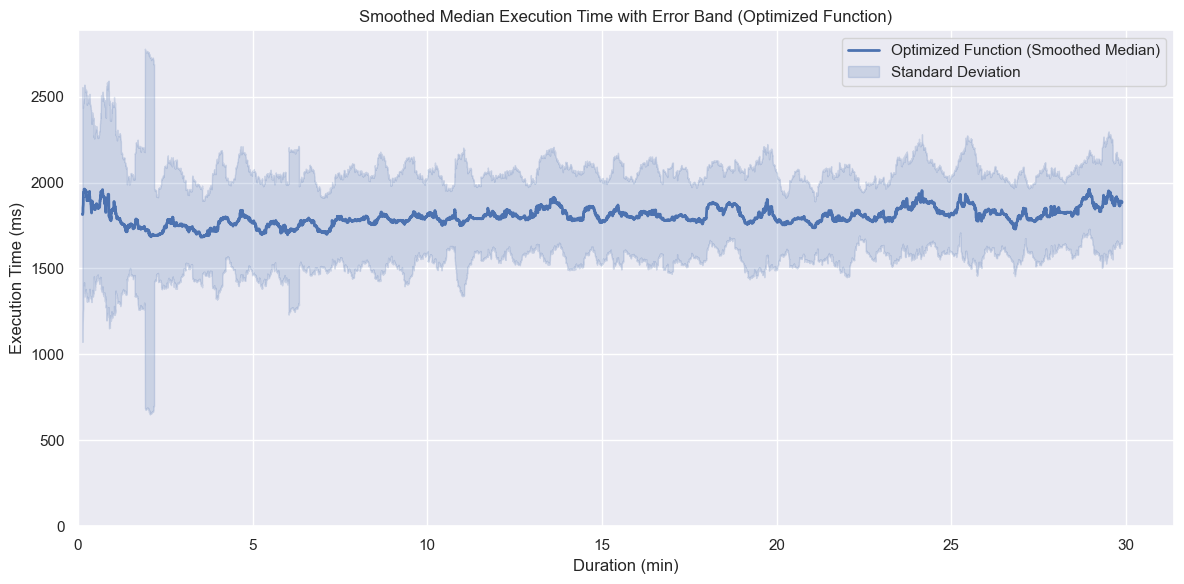

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_all_days_optimized is already loaded and preprocessed
df_optimized_all_days = df_all_days_optimized

# Sort the dataframe by duration_minutes to ensure proper rolling calculations
df_optimized_all_days = df_optimized_all_days.sort_values(by='duration_minutes')

# Define the rolling window size (e.g., 5 minutes)
window_size = 50  # Adjust this based on your data density and desired smoothness

# Calculate the rolling median and standard deviation
df_optimized_all_days['smoothed_median'] = (
    df_optimized_all_days['execution_time']
    # .rolling(window=f'{window_size}min', on='duration_minutes', center=True)
    .rolling(window=window_size, center=True)
    .median()
)
df_optimized_all_days['smoothed_std'] = (
    df_optimized_all_days['execution_time']
    # .rolling(window=f'{window_size}min', on='duration_minutes', center=True)
    .rolling(window=window_size, center=True)
    .std()
)

# Drop rows with NaN values (introduced by rolling calculations)
df_optimized_all_days = df_optimized_all_days.dropna(subset=['smoothed_median', 'smoothed_std'])

# Plot the data
sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

plt.figure(figsize=(12, 6))

# Plot smoothed median execution time
sns.lineplot(
    data=df_optimized_all_days,
    x='duration_minutes',
    y='smoothed_median',
    color=palette[0],
    label='Optimized Function (Smoothed Median)',
    lw=2
)

# Add error band using standard deviation
plt.fill_between(
    df_optimized_all_days['duration_minutes'],
    df_optimized_all_days['smoothed_median'] - df_optimized_all_days['smoothed_std'],
    df_optimized_all_days['smoothed_median'] + df_optimized_all_days['smoothed_std'],
    color=palette[0],
    alpha=0.2,
    label='Standard Deviation'
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Smoothed Median Execution Time with Error Band (Optimized Function)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# Show plot
plt.show()